https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing Libraries
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [3]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [4]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


In [5]:
cdata = GetCIFAR10_TrainData(os.chdir(".."))
trainset = cdata.download_train_data()
testset = cdata.download_test_data()

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
len(trainset), len(validset), len(testset)

(45000, 5000, 10000)

In [7]:
BATCH_SIZE = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# The Model - RESNET18


In [8]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [9]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 32
        
        self.conv = conv3x3(in_channels=3, out_channels=32)
        self.bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=32, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=64, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block=block, out_channels=128, blocks=layers[2], stride=2)
        self.layer4 = self.make_layer(block=block, out_channels=256, blocks=layers[3], stride=2)

        self.avg_pool = nn.AvgPool2d(4)
        self.fc = nn.Linear(256, num_classes)
        # self.fc = nn.Linear(128, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    return ResNet(ResidualBlock, [4, 6, 7, 2])
    # return ResNet(ResidualBlock, [2, 2, 2])

In [10]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
    ResidualBlock-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 32,

In [11]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        # train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        # print statistics
        
        running_loss += loss.item()
        pbar.set_description(desc=f'Batch_id={batch_idx} Batch Loss={loss.item()} Running Loss={running_loss} Running Accuracy={100*correct/processed:0.2f}')
        # train_acc.append(100*correct/processed)
    
    train_losses.append(running_loss)
    train_acc.append(100*correct/processed)

In [12]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified, correct / len(test_dataloader.dataset)

In [13]:
def model_evaluation(model, device, loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = F.nll_loss(y_pred, y)
        
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y.view_as(pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    epoch_loss / len(loader.dataset), epoch_acc, len(loader.dataset),
    100. * epoch_acc / len(loader.dataset)))

    return epoch_loss, epoch_acc / len(loader.dataset)

In [14]:
# Defining parameters

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [15]:
import pandas

def save_to_csv(csvname, train_losses, train_accs, test_losses, test_accs):
  df = pandas.DataFrame()
  df["epoch"] = [i+1 for i in range(len(train_losses))]
  df["train_loss"] = train_losses
  df["test_loss"] = test_losses
  df["train_acc"] = train_accs
  df["test_acc"] = test_accs
  df.to_csv(csvname)

In [16]:
# Training the model

train_acc = []
train_losses = []
valid_accs = []
valid_losses = []
test_acc = []
test_losses = []
min_valid_loss = None
max_acc = None

EPOCHS = 120

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)

    # Validating the model for the current epoch
    valid_loss, valid_acc = model_evaluation(model, device, validloader)  

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if not min_valid_loss:
      min_valid_loss = valid_loss
    else:
      if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model, "best_model.pickle")

    scheduler.step(train_losses[-1])
    # scheduler.step(valid_loss)

    misclassified, test_acc2 = model_testing(model, device, testloader, test_acc, test_losses)

    if not max_acc:
      max_acc = test_acc2
    else:
      if test_acc2 > max_acc:
        max_acc = test_acc2
        torch.save(model, "best_test_acc_model.pickle")

    save_to_csv("12_resnet_2_2_2_2_inchannels_32.csv", train_losses, train_acc, test_losses, test_acc)
  

EPOCHS : 0


Batch_id=87 Batch Loss=1.5296087265014648 Running Loss=155.55280578136444 Running Accuracy=33.95: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0029, Accuracy: 2357/5000 (47.14%)


Test set: Average loss: 1.4323, Accuracy: 4648/10000 (46.48%)

EPOCHS : 1


Batch_id=87 Batch Loss=1.271203875541687 Running Loss=116.73086941242218 Running Accuracy=51.81: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]



Validation set: Average loss: 0.0026, Accuracy: 2638/5000 (52.76%)


Test set: Average loss: 1.3063, Accuracy: 5222/10000 (52.22%)

EPOCHS : 2


Batch_id=87 Batch Loss=0.9230854511260986 Running Loss=98.32372081279755 Running Accuracy=60.18: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]



Validation set: Average loss: 0.0020, Accuracy: 3214/5000 (64.28%)


Test set: Average loss: 1.0062, Accuracy: 6415/10000 (64.15%)

EPOCHS : 3


Batch_id=87 Batch Loss=1.0112652778625488 Running Loss=85.37562870979309 Running Accuracy=65.59: 100%|██████████| 88/88 [00:44<00:00,  1.96it/s]



Validation set: Average loss: 0.0019, Accuracy: 3306/5000 (66.12%)


Test set: Average loss: 0.9644, Accuracy: 6600/10000 (66.00%)

EPOCHS : 4


Batch_id=87 Batch Loss=0.7738590836524963 Running Loss=76.1226499080658 Running Accuracy=69.44: 100%|██████████| 88/88 [00:44<00:00,  1.98it/s]



Validation set: Average loss: 0.0017, Accuracy: 3526/5000 (70.52%)


Test set: Average loss: 0.8438, Accuracy: 7023/10000 (70.23%)

EPOCHS : 5


Batch_id=87 Batch Loss=0.741563618183136 Running Loss=68.1270204782486 Running Accuracy=72.63: 100%|██████████| 88/88 [00:43<00:00,  2.00it/s]



Validation set: Average loss: 0.0018, Accuracy: 3482/5000 (69.64%)


Test set: Average loss: 0.9436, Accuracy: 6910/10000 (69.10%)

EPOCHS : 6


Batch_id=87 Batch Loss=0.6433463096618652 Running Loss=62.108815014362335 Running Accuracy=75.35: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]



Validation set: Average loss: 0.0014, Accuracy: 3747/5000 (74.94%)


Test set: Average loss: 0.7441, Accuracy: 7501/10000 (75.01%)

EPOCHS : 7


Batch_id=87 Batch Loss=0.6231992244720459 Running Loss=57.190145552158356 Running Accuracy=77.21: 100%|██████████| 88/88 [00:46<00:00,  1.88it/s]



Validation set: Average loss: 0.0019, Accuracy: 3433/5000 (68.66%)


Test set: Average loss: 0.9253, Accuracy: 6912/10000 (69.12%)

EPOCHS : 8


Batch_id=87 Batch Loss=0.5699613690376282 Running Loss=53.6688916683197 Running Accuracy=78.74: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]



Validation set: Average loss: 0.0014, Accuracy: 3833/5000 (76.66%)


Test set: Average loss: 0.7264, Accuracy: 7574/10000 (75.74%)

EPOCHS : 9


Batch_id=87 Batch Loss=0.46419844031333923 Running Loss=50.681207090616226 Running Accuracy=79.84: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0012, Accuracy: 3985/5000 (79.70%)


Test set: Average loss: 0.6445, Accuracy: 7800/10000 (78.00%)

EPOCHS : 10


Batch_id=87 Batch Loss=0.5894016623497009 Running Loss=47.24432730674744 Running Accuracy=81.10: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0011, Accuracy: 4037/5000 (80.74%)


Test set: Average loss: 0.5630, Accuracy: 8083/10000 (80.83%)

EPOCHS : 11


Batch_id=87 Batch Loss=0.5292217135429382 Running Loss=44.52305814623833 Running Accuracy=82.24: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0012, Accuracy: 3953/5000 (79.06%)


Test set: Average loss: 0.6054, Accuracy: 7888/10000 (78.88%)

EPOCHS : 12


Batch_id=87 Batch Loss=0.4866498112678528 Running Loss=41.80185613036156 Running Accuracy=83.17: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0011, Accuracy: 4031/5000 (80.62%)


Test set: Average loss: 0.6155, Accuracy: 7926/10000 (79.26%)

EPOCHS : 13


Batch_id=87 Batch Loss=0.4656330645084381 Running Loss=40.62476748228073 Running Accuracy=83.82: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0011, Accuracy: 4108/5000 (82.16%)


Test set: Average loss: 0.5611, Accuracy: 8123/10000 (81.23%)

EPOCHS : 14


Batch_id=87 Batch Loss=0.4809301495552063 Running Loss=38.349103540182114 Running Accuracy=84.94: 100%|██████████| 88/88 [00:47<00:00,  1.87it/s]



Validation set: Average loss: 0.0011, Accuracy: 4070/5000 (81.40%)


Test set: Average loss: 0.6026, Accuracy: 8080/10000 (80.80%)

EPOCHS : 15


Batch_id=87 Batch Loss=0.39303019642829895 Running Loss=37.69826912879944 Running Accuracy=84.87: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0011, Accuracy: 4122/5000 (82.44%)


Test set: Average loss: 0.5539, Accuracy: 8159/10000 (81.59%)

EPOCHS : 16


Batch_id=87 Batch Loss=0.3893365263938904 Running Loss=34.99620881676674 Running Accuracy=85.97: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]



Validation set: Average loss: 0.0012, Accuracy: 4053/5000 (81.06%)


Test set: Average loss: 0.6480, Accuracy: 7955/10000 (79.55%)

EPOCHS : 17


Batch_id=87 Batch Loss=0.3786093294620514 Running Loss=33.43481287360191 Running Accuracy=86.78: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0010, Accuracy: 4168/5000 (83.36%)


Test set: Average loss: 0.5608, Accuracy: 8204/10000 (82.04%)

EPOCHS : 18


Batch_id=87 Batch Loss=0.3297271430492401 Running Loss=32.51637688279152 Running Accuracy=86.98: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0009, Accuracy: 4266/5000 (85.32%)


Test set: Average loss: 0.4880, Accuracy: 8369/10000 (83.69%)

EPOCHS : 19


Batch_id=87 Batch Loss=0.43486487865448 Running Loss=31.160917729139328 Running Accuracy=87.51: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0011, Accuracy: 4109/5000 (82.18%)


Test set: Average loss: 0.5592, Accuracy: 8162/10000 (81.62%)

EPOCHS : 20


Batch_id=87 Batch Loss=0.3238956928253174 Running Loss=29.78856861591339 Running Accuracy=88.06: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0010, Accuracy: 4151/5000 (83.02%)


Test set: Average loss: 0.5503, Accuracy: 8227/10000 (82.27%)

EPOCHS : 21


Batch_id=87 Batch Loss=0.38399288058280945 Running Loss=28.566907346248627 Running Accuracy=88.77: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4257/5000 (85.14%)


Test set: Average loss: 0.4551, Accuracy: 8487/10000 (84.87%)

EPOCHS : 22


Batch_id=87 Batch Loss=0.3300332725048065 Running Loss=27.76033629477024 Running Accuracy=88.96: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0010, Accuracy: 4147/5000 (82.94%)


Test set: Average loss: 0.5386, Accuracy: 8231/10000 (82.31%)

EPOCHS : 23


Batch_id=87 Batch Loss=0.3738483488559723 Running Loss=26.510128557682037 Running Accuracy=89.40: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4288/5000 (85.76%)


Test set: Average loss: 0.4621, Accuracy: 8506/10000 (85.06%)

EPOCHS : 24


Batch_id=87 Batch Loss=0.2468928098678589 Running Loss=25.384059563279152 Running Accuracy=89.90: 100%|██████████| 88/88 [00:46<00:00,  1.88it/s]



Validation set: Average loss: 0.0009, Accuracy: 4285/5000 (85.70%)


Test set: Average loss: 0.4795, Accuracy: 8471/10000 (84.71%)

EPOCHS : 25


Batch_id=87 Batch Loss=0.2721026837825775 Running Loss=24.583565309643745 Running Accuracy=90.03: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]



Validation set: Average loss: 0.0013, Accuracy: 4048/5000 (80.96%)


Test set: Average loss: 0.6847, Accuracy: 8012/10000 (80.12%)

EPOCHS : 26


Batch_id=87 Batch Loss=0.2810018062591553 Running Loss=23.896741271018982 Running Accuracy=90.35: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4263/5000 (85.26%)


Test set: Average loss: 0.5178, Accuracy: 8405/10000 (84.05%)

EPOCHS : 27


Batch_id=87 Batch Loss=0.24947883188724518 Running Loss=22.782157972455025 Running Accuracy=90.95: 100%|██████████| 88/88 [00:44<00:00,  1.96it/s]



Validation set: Average loss: 0.0011, Accuracy: 4138/5000 (82.76%)


Test set: Average loss: 0.5854, Accuracy: 8242/10000 (82.42%)

EPOCHS : 28


Batch_id=87 Batch Loss=0.28354373574256897 Running Loss=21.89918354153633 Running Accuracy=91.24: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0010, Accuracy: 4243/5000 (84.86%)


Test set: Average loss: 0.5381, Accuracy: 8426/10000 (84.26%)

EPOCHS : 29


Batch_id=87 Batch Loss=0.2679087221622467 Running Loss=21.285569220781326 Running Accuracy=91.43: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4418/5000 (88.36%)


Test set: Average loss: 0.4027, Accuracy: 8700/10000 (87.00%)

EPOCHS : 30


Batch_id=87 Batch Loss=0.22748512029647827 Running Loss=20.418181985616684 Running Accuracy=91.83: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0009, Accuracy: 4271/5000 (85.42%)


Test set: Average loss: 0.5263, Accuracy: 8423/10000 (84.23%)

EPOCHS : 31


Batch_id=87 Batch Loss=0.19722408056259155 Running Loss=20.196137592196465 Running Accuracy=91.81: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4325/5000 (86.50%)


Test set: Average loss: 0.4800, Accuracy: 8517/10000 (85.17%)

EPOCHS : 32


Batch_id=87 Batch Loss=0.21675175428390503 Running Loss=19.213197469711304 Running Accuracy=92.19: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0008, Accuracy: 4376/5000 (87.52%)


Test set: Average loss: 0.4517, Accuracy: 8587/10000 (85.87%)

EPOCHS : 33


Batch_id=87 Batch Loss=0.21971632540225983 Running Loss=18.428090006113052 Running Accuracy=92.53: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0008, Accuracy: 4352/5000 (87.04%)


Test set: Average loss: 0.4611, Accuracy: 8612/10000 (86.12%)

EPOCHS : 34


Batch_id=87 Batch Loss=0.18187430500984192 Running Loss=18.01723676919937 Running Accuracy=92.73: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0008, Accuracy: 4378/5000 (87.56%)


Test set: Average loss: 0.4572, Accuracy: 8604/10000 (86.04%)

EPOCHS : 35


Batch_id=87 Batch Loss=0.17603075504302979 Running Loss=17.109865456819534 Running Accuracy=93.08: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]



Validation set: Average loss: 0.0009, Accuracy: 4324/5000 (86.48%)


Test set: Average loss: 0.4704, Accuracy: 8597/10000 (85.97%)

EPOCHS : 36


Batch_id=87 Batch Loss=0.16707198321819305 Running Loss=16.586954459547997 Running Accuracy=93.30: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]



Validation set: Average loss: 0.0009, Accuracy: 4320/5000 (86.40%)


Test set: Average loss: 0.4976, Accuracy: 8540/10000 (85.40%)

EPOCHS : 37


Batch_id=87 Batch Loss=0.1969866156578064 Running Loss=15.834511309862137 Running Accuracy=93.70: 100%|██████████| 88/88 [00:43<00:00,  2.02it/s]



Validation set: Average loss: 0.0009, Accuracy: 4315/5000 (86.30%)


Test set: Average loss: 0.5111, Accuracy: 8539/10000 (85.39%)

EPOCHS : 38


Batch_id=87 Batch Loss=0.15574820339679718 Running Loss=16.20096715539694 Running Accuracy=93.40: 100%|██████████| 88/88 [00:44<00:00,  1.98it/s]



Validation set: Average loss: 0.0007, Accuracy: 4444/5000 (88.88%)


Test set: Average loss: 0.4247, Accuracy: 8718/10000 (87.18%)

EPOCHS : 39


Batch_id=87 Batch Loss=0.17567230761051178 Running Loss=15.297408603131771 Running Accuracy=93.80: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]



Validation set: Average loss: 0.0009, Accuracy: 4308/5000 (86.16%)


Test set: Average loss: 0.5110, Accuracy: 8569/10000 (85.69%)

EPOCHS : 40


Batch_id=87 Batch Loss=0.17006400227546692 Running Loss=14.315079107880592 Running Accuracy=94.34: 100%|██████████| 88/88 [00:44<00:00,  1.97it/s]



Validation set: Average loss: 0.0009, Accuracy: 4361/5000 (87.22%)


Test set: Average loss: 0.4991, Accuracy: 8559/10000 (85.59%)

EPOCHS : 41


Batch_id=87 Batch Loss=0.1285538524389267 Running Loss=14.32049885392189 Running Accuracy=94.17: 100%|██████████| 88/88 [00:44<00:00,  1.98it/s]



Validation set: Average loss: 0.0011, Accuracy: 4218/5000 (84.36%)


Test set: Average loss: 0.6091, Accuracy: 8363/10000 (83.63%)

EPOCHS : 42


Batch_id=87 Batch Loss=0.17962415516376495 Running Loss=13.622296996414661 Running Accuracy=94.63: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0009, Accuracy: 4370/5000 (87.40%)


Test set: Average loss: 0.4755, Accuracy: 8652/10000 (86.52%)

EPOCHS : 43


Batch_id=87 Batch Loss=0.15485621988773346 Running Loss=13.022463947534561 Running Accuracy=94.79: 100%|██████████| 88/88 [00:44<00:00,  1.98it/s]



Validation set: Average loss: 0.0008, Accuracy: 4405/5000 (88.10%)


Test set: Average loss: 0.4344, Accuracy: 8723/10000 (87.23%)

EPOCHS : 44


Batch_id=87 Batch Loss=0.17390041053295135 Running Loss=13.056647598743439 Running Accuracy=94.74: 100%|██████████| 88/88 [00:44<00:00,  1.97it/s]



Validation set: Average loss: 0.0008, Accuracy: 4412/5000 (88.24%)


Test set: Average loss: 0.4326, Accuracy: 8748/10000 (87.48%)

EPOCHS : 45


Batch_id=87 Batch Loss=0.18658587336540222 Running Loss=12.912600107491016 Running Accuracy=94.75: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0008, Accuracy: 4432/5000 (88.64%)


Test set: Average loss: 0.4487, Accuracy: 8728/10000 (87.28%)

EPOCHS : 46


Batch_id=87 Batch Loss=0.16482703387737274 Running Loss=12.185560129582882 Running Accuracy=95.03: 100%|██████████| 88/88 [00:44<00:00,  1.97it/s]



Validation set: Average loss: 0.0009, Accuracy: 4378/5000 (87.56%)


Test set: Average loss: 0.4807, Accuracy: 8665/10000 (86.65%)

EPOCHS : 47


Batch_id=87 Batch Loss=0.13301314413547516 Running Loss=11.936986684799194 Running Accuracy=95.14: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]



Validation set: Average loss: 0.0009, Accuracy: 4338/5000 (86.76%)


Test set: Average loss: 0.5217, Accuracy: 8602/10000 (86.02%)

EPOCHS : 48


Batch_id=87 Batch Loss=0.12147975713014603 Running Loss=11.89654491096735 Running Accuracy=95.23: 100%|██████████| 88/88 [00:44<00:00,  2.00it/s]



Validation set: Average loss: 0.0011, Accuracy: 4279/5000 (85.58%)


Test set: Average loss: 0.5897, Accuracy: 8422/10000 (84.22%)

EPOCHS : 49


Batch_id=87 Batch Loss=0.1055050790309906 Running Loss=11.302980817854404 Running Accuracy=95.48: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4397/5000 (87.94%)


Test set: Average loss: 0.4881, Accuracy: 8627/10000 (86.27%)

EPOCHS : 50


Batch_id=87 Batch Loss=0.1497359424829483 Running Loss=11.086706593632698 Running Accuracy=95.60: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]



Validation set: Average loss: 0.0011, Accuracy: 4290/5000 (85.80%)


Test set: Average loss: 0.5790, Accuracy: 8489/10000 (84.89%)

EPOCHS : 51


Batch_id=87 Batch Loss=0.10252860188484192 Running Loss=11.054316401481628 Running Accuracy=95.48: 100%|██████████| 88/88 [00:44<00:00,  1.96it/s]



Validation set: Average loss: 0.0011, Accuracy: 4304/5000 (86.08%)


Test set: Average loss: 0.5899, Accuracy: 8473/10000 (84.73%)

EPOCHS : 52


Batch_id=87 Batch Loss=0.09346731007099152 Running Loss=10.262692928314209 Running Accuracy=95.76: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0009, Accuracy: 4417/5000 (88.34%)


Test set: Average loss: 0.4905, Accuracy: 8694/10000 (86.94%)

EPOCHS : 53


Batch_id=87 Batch Loss=0.12100031226873398 Running Loss=10.54791708290577 Running Accuracy=95.81: 100%|██████████| 88/88 [00:44<00:00,  1.96it/s]



Validation set: Average loss: 0.0008, Accuracy: 4394/5000 (87.88%)


Test set: Average loss: 0.4692, Accuracy: 8735/10000 (87.35%)

EPOCHS : 54


Batch_id=87 Batch Loss=0.08734691143035889 Running Loss=10.121537193655968 Running Accuracy=95.83: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]



Validation set: Average loss: 0.0009, Accuracy: 4341/5000 (86.82%)


Test set: Average loss: 0.4978, Accuracy: 8645/10000 (86.45%)

EPOCHS : 55


Batch_id=87 Batch Loss=0.09614967554807663 Running Loss=9.41738822311163 Running Accuracy=96.27: 100%|██████████| 88/88 [00:44<00:00,  1.97it/s]



Validation set: Average loss: 0.0008, Accuracy: 4447/5000 (88.94%)


Test set: Average loss: 0.4706, Accuracy: 8766/10000 (87.66%)

EPOCHS : 56


Batch_id=87 Batch Loss=0.08611800521612167 Running Loss=8.616334564983845 Running Accuracy=96.60: 100%|██████████| 88/88 [00:44<00:00,  1.96it/s]



Validation set: Average loss: 0.0009, Accuracy: 4415/5000 (88.30%)


Test set: Average loss: 0.4984, Accuracy: 8702/10000 (87.02%)

EPOCHS : 57


Batch_id=87 Batch Loss=0.11634145677089691 Running Loss=8.982176579535007 Running Accuracy=96.48: 100%|██████████| 88/88 [00:44<00:00,  1.97it/s]



Validation set: Average loss: 0.0009, Accuracy: 4389/5000 (87.78%)


Test set: Average loss: 0.4961, Accuracy: 8646/10000 (86.46%)

EPOCHS : 58


Batch_id=87 Batch Loss=0.08574965596199036 Running Loss=8.62243838608265 Running Accuracy=96.53: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]



Validation set: Average loss: 0.0008, Accuracy: 4453/5000 (89.06%)


Test set: Average loss: 0.4582, Accuracy: 8800/10000 (88.00%)

EPOCHS : 59


Batch_id=87 Batch Loss=0.1170661598443985 Running Loss=8.455412670969963 Running Accuracy=96.55: 100%|██████████| 88/88 [00:44<00:00,  1.96it/s]



Validation set: Average loss: 0.0010, Accuracy: 4370/5000 (87.40%)


Test set: Average loss: 0.5421, Accuracy: 8611/10000 (86.11%)

EPOCHS : 60


Batch_id=87 Batch Loss=0.08566022664308548 Running Loss=8.364674985408783 Running Accuracy=96.69: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4368/5000 (87.36%)


Test set: Average loss: 0.5309, Accuracy: 8650/10000 (86.50%)

EPOCHS : 61


Batch_id=87 Batch Loss=0.15730011463165283 Running Loss=8.148044604808092 Running Accuracy=96.79: 100%|██████████| 88/88 [00:44<00:00,  2.00it/s]



Validation set: Average loss: 0.0009, Accuracy: 4411/5000 (88.22%)


Test set: Average loss: 0.5342, Accuracy: 8682/10000 (86.82%)

EPOCHS : 62


Batch_id=87 Batch Loss=0.0806630402803421 Running Loss=8.17750521749258 Running Accuracy=96.74: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]



Validation set: Average loss: 0.0008, Accuracy: 4441/5000 (88.82%)


Test set: Average loss: 0.4654, Accuracy: 8758/10000 (87.58%)

EPOCHS : 63


Batch_id=87 Batch Loss=0.11186522245407104 Running Loss=7.947704203426838 Running Accuracy=96.77: 100%|██████████| 88/88 [00:44<00:00,  1.97it/s]



Validation set: Average loss: 0.0009, Accuracy: 4425/5000 (88.50%)


Test set: Average loss: 0.4919, Accuracy: 8759/10000 (87.59%)

EPOCHS : 64


Batch_id=87 Batch Loss=0.07143102586269379 Running Loss=7.600564617663622 Running Accuracy=96.98: 100%|██████████| 88/88 [00:43<00:00,  2.01it/s]



Validation set: Average loss: 0.0008, Accuracy: 4442/5000 (88.84%)


Test set: Average loss: 0.4827, Accuracy: 8763/10000 (87.63%)

EPOCHS : 65


Batch_id=87 Batch Loss=0.08489195257425308 Running Loss=7.667497336864471 Running Accuracy=97.01: 100%|██████████| 88/88 [00:43<00:00,  2.02it/s]



Validation set: Average loss: 0.0009, Accuracy: 4419/5000 (88.38%)


Test set: Average loss: 0.4936, Accuracy: 8716/10000 (87.16%)

EPOCHS : 66


Batch_id=87 Batch Loss=0.1047423705458641 Running Loss=7.905076798051596 Running Accuracy=96.89: 100%|██████████| 88/88 [00:43<00:00,  2.02it/s]



Validation set: Average loss: 0.0011, Accuracy: 4288/5000 (85.76%)


Test set: Average loss: 0.5836, Accuracy: 8542/10000 (85.42%)

EPOCHS : 67


Batch_id=87 Batch Loss=0.08865166455507278 Running Loss=7.1351727694272995 Running Accuracy=97.20: 100%|██████████| 88/88 [00:44<00:00,  1.98it/s]



Validation set: Average loss: 0.0008, Accuracy: 4476/5000 (89.52%)


Test set: Average loss: 0.4595, Accuracy: 8789/10000 (87.89%)

EPOCHS : 68


Batch_id=87 Batch Loss=0.06459210813045502 Running Loss=6.625645708292723 Running Accuracy=97.39: 100%|██████████| 88/88 [00:44<00:00,  1.98it/s]



Validation set: Average loss: 0.0010, Accuracy: 4397/5000 (87.94%)


Test set: Average loss: 0.5530, Accuracy: 8683/10000 (86.83%)

EPOCHS : 69


Batch_id=87 Batch Loss=0.07399657368659973 Running Loss=6.784013252705336 Running Accuracy=97.21: 100%|██████████| 88/88 [00:44<00:00,  1.98it/s]



Validation set: Average loss: 0.0009, Accuracy: 4389/5000 (87.78%)


Test set: Average loss: 0.5268, Accuracy: 8709/10000 (87.09%)

EPOCHS : 70


Batch_id=87 Batch Loss=0.07134187966585159 Running Loss=6.560276009142399 Running Accuracy=97.40: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0008, Accuracy: 4501/5000 (90.02%)


Test set: Average loss: 0.4708, Accuracy: 8820/10000 (88.20%)

EPOCHS : 71


Batch_id=87 Batch Loss=0.08027122914791107 Running Loss=6.705123286694288 Running Accuracy=97.35: 100%|██████████| 88/88 [00:44<00:00,  1.96it/s]



Validation set: Average loss: 0.0009, Accuracy: 4437/5000 (88.74%)


Test set: Average loss: 0.5056, Accuracy: 8765/10000 (87.65%)

EPOCHS : 72


Batch_id=87 Batch Loss=0.08249791711568832 Running Loss=6.234429936856031 Running Accuracy=97.58: 100%|██████████| 88/88 [00:44<00:00,  1.97it/s]



Validation set: Average loss: 0.0009, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.5247, Accuracy: 8710/10000 (87.10%)

EPOCHS : 73


Batch_id=87 Batch Loss=0.05645202472805977 Running Loss=6.529179956763983 Running Accuracy=97.35: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]



Validation set: Average loss: 0.0009, Accuracy: 4438/5000 (88.76%)


Test set: Average loss: 0.5099, Accuracy: 8737/10000 (87.37%)

EPOCHS : 74


Batch_id=87 Batch Loss=0.07711256295442581 Running Loss=5.890403378754854 Running Accuracy=97.66: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4429/5000 (88.58%)


Test set: Average loss: 0.5303, Accuracy: 8727/10000 (87.27%)

EPOCHS : 75


Batch_id=87 Batch Loss=0.06986203789710999 Running Loss=5.889244951307774 Running Accuracy=97.65: 100%|██████████| 88/88 [00:44<00:00,  1.96it/s]



Validation set: Average loss: 0.0009, Accuracy: 4425/5000 (88.50%)


Test set: Average loss: 0.4890, Accuracy: 8780/10000 (87.80%)

EPOCHS : 76


Batch_id=87 Batch Loss=0.07073282450437546 Running Loss=5.713030315935612 Running Accuracy=97.74: 100%|██████████| 88/88 [00:44<00:00,  1.97it/s]



Validation set: Average loss: 0.0010, Accuracy: 4416/5000 (88.32%)


Test set: Average loss: 0.5599, Accuracy: 8706/10000 (87.06%)

EPOCHS : 77


Batch_id=87 Batch Loss=0.06528966128826141 Running Loss=5.867250625044107 Running Accuracy=97.64: 100%|██████████| 88/88 [00:43<00:00,  2.02it/s]



Validation set: Average loss: 0.0008, Accuracy: 4483/5000 (89.66%)


Test set: Average loss: 0.4870, Accuracy: 8853/10000 (88.53%)

EPOCHS : 78


Batch_id=87 Batch Loss=0.08202335238456726 Running Loss=5.808167431503534 Running Accuracy=97.74: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]



Validation set: Average loss: 0.0008, Accuracy: 4482/5000 (89.64%)


Test set: Average loss: 0.4772, Accuracy: 8831/10000 (88.31%)

EPOCHS : 79


Batch_id=87 Batch Loss=0.0825200155377388 Running Loss=5.652682032436132 Running Accuracy=97.72: 100%|██████████| 88/88 [00:43<00:00,  2.03it/s]



Validation set: Average loss: 0.0009, Accuracy: 4456/5000 (89.12%)


Test set: Average loss: 0.4786, Accuracy: 8820/10000 (88.20%)

EPOCHS : 80


Batch_id=87 Batch Loss=0.0919019877910614 Running Loss=5.308032460510731 Running Accuracy=97.96: 100%|██████████| 88/88 [00:42<00:00,  2.06it/s]



Validation set: Average loss: 0.0010, Accuracy: 4415/5000 (88.30%)


Test set: Average loss: 0.5164, Accuracy: 8733/10000 (87.33%)

EPOCHS : 81


Batch_id=87 Batch Loss=0.02769191935658455 Running Loss=5.2028593942523 Running Accuracy=97.97: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]



Validation set: Average loss: 0.0009, Accuracy: 4426/5000 (88.52%)


Test set: Average loss: 0.5220, Accuracy: 8752/10000 (87.52%)

EPOCHS : 82


Batch_id=87 Batch Loss=0.060446057468652725 Running Loss=5.447277411818504 Running Accuracy=97.90: 100%|██████████| 88/88 [00:44<00:00,  1.97it/s]



Validation set: Average loss: 0.0008, Accuracy: 4483/5000 (89.66%)


Test set: Average loss: 0.4995, Accuracy: 8814/10000 (88.14%)

EPOCHS : 83


Batch_id=87 Batch Loss=0.06223557889461517 Running Loss=5.021903499960899 Running Accuracy=98.04: 100%|██████████| 88/88 [00:43<00:00,  2.02it/s]



Validation set: Average loss: 0.0009, Accuracy: 4445/5000 (88.90%)


Test set: Average loss: 0.5439, Accuracy: 8748/10000 (87.48%)

EPOCHS : 84


Batch_id=87 Batch Loss=0.061963148415088654 Running Loss=5.121657177805901 Running Accuracy=98.00: 100%|██████████| 88/88 [00:43<00:00,  2.04it/s]



Validation set: Average loss: 0.0009, Accuracy: 4444/5000 (88.88%)


Test set: Average loss: 0.5275, Accuracy: 8769/10000 (87.69%)

EPOCHS : 85


Batch_id=87 Batch Loss=0.05258775129914284 Running Loss=4.791909251362085 Running Accuracy=98.12: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]



Validation set: Average loss: 0.0008, Accuracy: 4499/5000 (89.98%)


Test set: Average loss: 0.4606, Accuracy: 8862/10000 (88.62%)

EPOCHS : 86


Batch_id=87 Batch Loss=0.07173348218202591 Running Loss=4.911355225369334 Running Accuracy=98.01: 100%|██████████| 88/88 [00:44<00:00,  2.00it/s]



Validation set: Average loss: 0.0010, Accuracy: 4433/5000 (88.66%)


Test set: Average loss: 0.5469, Accuracy: 8763/10000 (87.63%)

EPOCHS : 87


Batch_id=87 Batch Loss=0.056025099009275436 Running Loss=4.735644435510039 Running Accuracy=98.12: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]



Validation set: Average loss: 0.0008, Accuracy: 4480/5000 (89.60%)


Test set: Average loss: 0.4809, Accuracy: 8842/10000 (88.42%)

EPOCHS : 88


Batch_id=87 Batch Loss=0.07339676469564438 Running Loss=4.894755087792873 Running Accuracy=97.95: 100%|██████████| 88/88 [00:43<00:00,  2.04it/s]



Validation set: Average loss: 0.0009, Accuracy: 4483/5000 (89.66%)


Test set: Average loss: 0.5092, Accuracy: 8838/10000 (88.38%)

EPOCHS : 89


Batch_id=87 Batch Loss=0.05805028975009918 Running Loss=4.802237890660763 Running Accuracy=98.08: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0010, Accuracy: 4434/5000 (88.68%)


Test set: Average loss: 0.5383, Accuracy: 8725/10000 (87.25%)

EPOCHS : 90


Batch_id=87 Batch Loss=0.05072690173983574 Running Loss=4.472138682380319 Running Accuracy=98.25: 100%|██████████| 88/88 [00:43<00:00,  2.01it/s]



Validation set: Average loss: 0.0009, Accuracy: 4468/5000 (89.36%)


Test set: Average loss: 0.4843, Accuracy: 8840/10000 (88.40%)

EPOCHS : 91


Batch_id=87 Batch Loss=0.06512333452701569 Running Loss=4.533462373539805 Running Accuracy=98.24: 100%|██████████| 88/88 [00:43<00:00,  2.03it/s]



Validation set: Average loss: 0.0008, Accuracy: 4523/5000 (90.46%)


Test set: Average loss: 0.4671, Accuracy: 8861/10000 (88.61%)

EPOCHS : 92


Batch_id=87 Batch Loss=0.051024049520492554 Running Loss=4.664260542020202 Running Accuracy=98.16: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]



Validation set: Average loss: 0.0008, Accuracy: 4498/5000 (89.96%)


Test set: Average loss: 0.4825, Accuracy: 8856/10000 (88.56%)

EPOCHS : 93


Batch_id=87 Batch Loss=0.06431563943624496 Running Loss=4.790986981242895 Running Accuracy=98.15: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0009, Accuracy: 4466/5000 (89.32%)

Epoch 00094: reducing learning rate of group 0 to 1.0000e-03.

Test set: Average loss: 0.5110, Accuracy: 8783/10000 (87.83%)

EPOCHS : 94


Batch_id=87 Batch Loss=0.028965475037693977 Running Loss=3.1954235145822167 Running Accuracy=98.77: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]



Validation set: Average loss: 0.0007, Accuracy: 4553/5000 (91.06%)


Test set: Average loss: 0.4173, Accuracy: 8964/10000 (89.64%)

EPOCHS : 95


Batch_id=87 Batch Loss=0.018583565950393677 Running Loss=2.213301360607147 Running Accuracy=99.23: 100%|██████████| 88/88 [00:44<00:00,  1.96it/s]



Validation set: Average loss: 0.0007, Accuracy: 4557/5000 (91.14%)


Test set: Average loss: 0.4135, Accuracy: 8968/10000 (89.68%)

EPOCHS : 96


Batch_id=87 Batch Loss=0.028803229331970215 Running Loss=2.1645198855549097 Running Accuracy=99.22: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0007, Accuracy: 4575/5000 (91.50%)


Test set: Average loss: 0.4045, Accuracy: 9000/10000 (90.00%)

EPOCHS : 97


Batch_id=87 Batch Loss=0.019564444199204445 Running Loss=1.979174475185573 Running Accuracy=99.29: 100%|██████████| 88/88 [00:42<00:00,  2.06it/s]



Validation set: Average loss: 0.0007, Accuracy: 4573/5000 (91.46%)


Test set: Average loss: 0.4043, Accuracy: 8993/10000 (89.93%)

EPOCHS : 98


Batch_id=87 Batch Loss=0.015665290877223015 Running Loss=1.752573762089014 Running Accuracy=99.38: 100%|██████████| 88/88 [00:44<00:00,  1.98it/s]



Validation set: Average loss: 0.0007, Accuracy: 4575/5000 (91.50%)


Test set: Average loss: 0.4054, Accuracy: 9001/10000 (90.01%)

EPOCHS : 99


Batch_id=87 Batch Loss=0.017650771886110306 Running Loss=1.6281226305291057 Running Accuracy=99.44: 100%|██████████| 88/88 [00:44<00:00,  1.97it/s]



Validation set: Average loss: 0.0007, Accuracy: 4588/5000 (91.76%)


Test set: Average loss: 0.4079, Accuracy: 8999/10000 (89.99%)

EPOCHS : 100


Batch_id=87 Batch Loss=0.02586347423493862 Running Loss=1.6464018542319536 Running Accuracy=99.44: 100%|██████████| 88/88 [00:44<00:00,  1.96it/s]



Validation set: Average loss: 0.0007, Accuracy: 4576/5000 (91.52%)


Test set: Average loss: 0.4048, Accuracy: 8995/10000 (89.95%)

EPOCHS : 101


Batch_id=87 Batch Loss=0.016839774325489998 Running Loss=1.5181043706834316 Running Accuracy=99.47: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]



Validation set: Average loss: 0.0007, Accuracy: 4572/5000 (91.44%)


Test set: Average loss: 0.4000, Accuracy: 9014/10000 (90.14%)

EPOCHS : 102


Batch_id=87 Batch Loss=0.017781974747776985 Running Loss=1.4111607819795609 Running Accuracy=99.51: 100%|██████████| 88/88 [00:44<00:00,  1.97it/s]



Validation set: Average loss: 0.0007, Accuracy: 4580/5000 (91.60%)


Test set: Average loss: 0.4011, Accuracy: 9012/10000 (90.12%)

EPOCHS : 103


Batch_id=87 Batch Loss=0.019495859742164612 Running Loss=1.4520291169174016 Running Accuracy=99.52: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]



Validation set: Average loss: 0.0007, Accuracy: 4585/5000 (91.70%)


Test set: Average loss: 0.4058, Accuracy: 9004/10000 (90.04%)

EPOCHS : 104


Batch_id=87 Batch Loss=0.02817896567285061 Running Loss=1.3371639675460756 Running Accuracy=99.59: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4596/5000 (91.92%)


Test set: Average loss: 0.4014, Accuracy: 9025/10000 (90.25%)

EPOCHS : 105


Batch_id=87 Batch Loss=0.012045527808368206 Running Loss=1.4104245607741177 Running Accuracy=99.54: 100%|██████████| 88/88 [00:44<00:00,  1.98it/s]



Validation set: Average loss: 0.0007, Accuracy: 4593/5000 (91.86%)


Test set: Average loss: 0.4048, Accuracy: 9007/10000 (90.07%)

EPOCHS : 106


Batch_id=87 Batch Loss=0.019826721400022507 Running Loss=1.3377557755447924 Running Accuracy=99.57: 100%|██████████| 88/88 [00:44<00:00,  1.96it/s]



Validation set: Average loss: 0.0007, Accuracy: 4582/5000 (91.64%)


Test set: Average loss: 0.4066, Accuracy: 8997/10000 (89.97%)

EPOCHS : 107


Batch_id=87 Batch Loss=0.014973643235862255 Running Loss=1.3334679948166013 Running Accuracy=99.54: 100%|██████████| 88/88 [00:45<00:00,  1.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4582/5000 (91.64%)


Test set: Average loss: 0.4055, Accuracy: 8995/10000 (89.95%)

EPOCHS : 108


Batch_id=87 Batch Loss=0.01191947516053915 Running Loss=1.2204613243229687 Running Accuracy=99.59: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4584/5000 (91.68%)


Test set: Average loss: 0.4078, Accuracy: 9002/10000 (90.02%)

EPOCHS : 109


Batch_id=87 Batch Loss=0.019794177263975143 Running Loss=1.3106485377065837 Running Accuracy=99.54: 100%|██████████| 88/88 [00:44<00:00,  1.97it/s]



Validation set: Average loss: 0.0007, Accuracy: 4582/5000 (91.64%)


Test set: Average loss: 0.4068, Accuracy: 9010/10000 (90.10%)

EPOCHS : 110


Batch_id=87 Batch Loss=0.021094907075166702 Running Loss=1.2407579263672233 Running Accuracy=99.61: 100%|██████████| 88/88 [00:45<00:00,  1.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4582/5000 (91.64%)


Test set: Average loss: 0.4051, Accuracy: 9007/10000 (90.07%)

EPOCHS : 111


Batch_id=87 Batch Loss=0.0119697330519557 Running Loss=1.1493305158801377 Running Accuracy=99.60: 100%|██████████| 88/88 [00:44<00:00,  2.00it/s]



Validation set: Average loss: 0.0007, Accuracy: 4580/5000 (91.60%)


Test set: Average loss: 0.4045, Accuracy: 9015/10000 (90.15%)

EPOCHS : 112


Batch_id=87 Batch Loss=0.023439444601535797 Running Loss=1.350935589056462 Running Accuracy=99.56: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0007, Accuracy: 4582/5000 (91.64%)


Test set: Average loss: 0.4031, Accuracy: 9016/10000 (90.16%)

EPOCHS : 113


Batch_id=87 Batch Loss=0.027395978569984436 Running Loss=1.1751713808625937 Running Accuracy=99.58: 100%|██████████| 88/88 [00:44<00:00,  1.98it/s]



Validation set: Average loss: 0.0007, Accuracy: 4592/5000 (91.84%)


Test set: Average loss: 0.4053, Accuracy: 9016/10000 (90.16%)

EPOCHS : 114


Batch_id=87 Batch Loss=0.011383694596588612 Running Loss=1.072921065846458 Running Accuracy=99.64: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]



Validation set: Average loss: 0.0007, Accuracy: 4587/5000 (91.74%)


Test set: Average loss: 0.4056, Accuracy: 9023/10000 (90.23%)

EPOCHS : 115


Batch_id=87 Batch Loss=0.01797054521739483 Running Loss=1.1811565794050694 Running Accuracy=99.60: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]



Validation set: Average loss: 0.0007, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.4050, Accuracy: 9025/10000 (90.25%)

EPOCHS : 116


Batch_id=87 Batch Loss=0.018939927220344543 Running Loss=1.0792617690749466 Running Accuracy=99.62: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]



Validation set: Average loss: 0.0007, Accuracy: 4585/5000 (91.70%)


Test set: Average loss: 0.4053, Accuracy: 9014/10000 (90.14%)

EPOCHS : 117


Batch_id=87 Batch Loss=0.015235367231070995 Running Loss=1.0398562597110868 Running Accuracy=99.65: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.4085, Accuracy: 9001/10000 (90.01%)

EPOCHS : 118


Batch_id=87 Batch Loss=0.03420797735452652 Running Loss=1.1412254348397255 Running Accuracy=99.62: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]



Validation set: Average loss: 0.0007, Accuracy: 4584/5000 (91.68%)


Test set: Average loss: 0.4066, Accuracy: 9021/10000 (90.21%)

EPOCHS : 119


Batch_id=87 Batch Loss=0.014480812475085258 Running Loss=1.0304651272017509 Running Accuracy=99.65: 100%|██████████| 88/88 [00:46<00:00,  1.88it/s]



Validation set: Average loss: 0.0007, Accuracy: 4582/5000 (91.64%)


Test set: Average loss: 0.4075, Accuracy: 9020/10000 (90.20%)



In [19]:
# Best model
model1 = torch.load("best_model.pickle")
model2 = torch.load("best_test_acc_model.pickle")
misclassified, _acc = model_testing(model1, device, testloader, test_acc, test_losses)
misclassified, _acc = model_testing(model2, device, testloader, test_acc, test_losses)


Test set: Average loss: 0.4014, Accuracy: 9025/10000 (90.25%)


Test set: Average loss: 0.4014, Accuracy: 9025/10000 (90.25%)



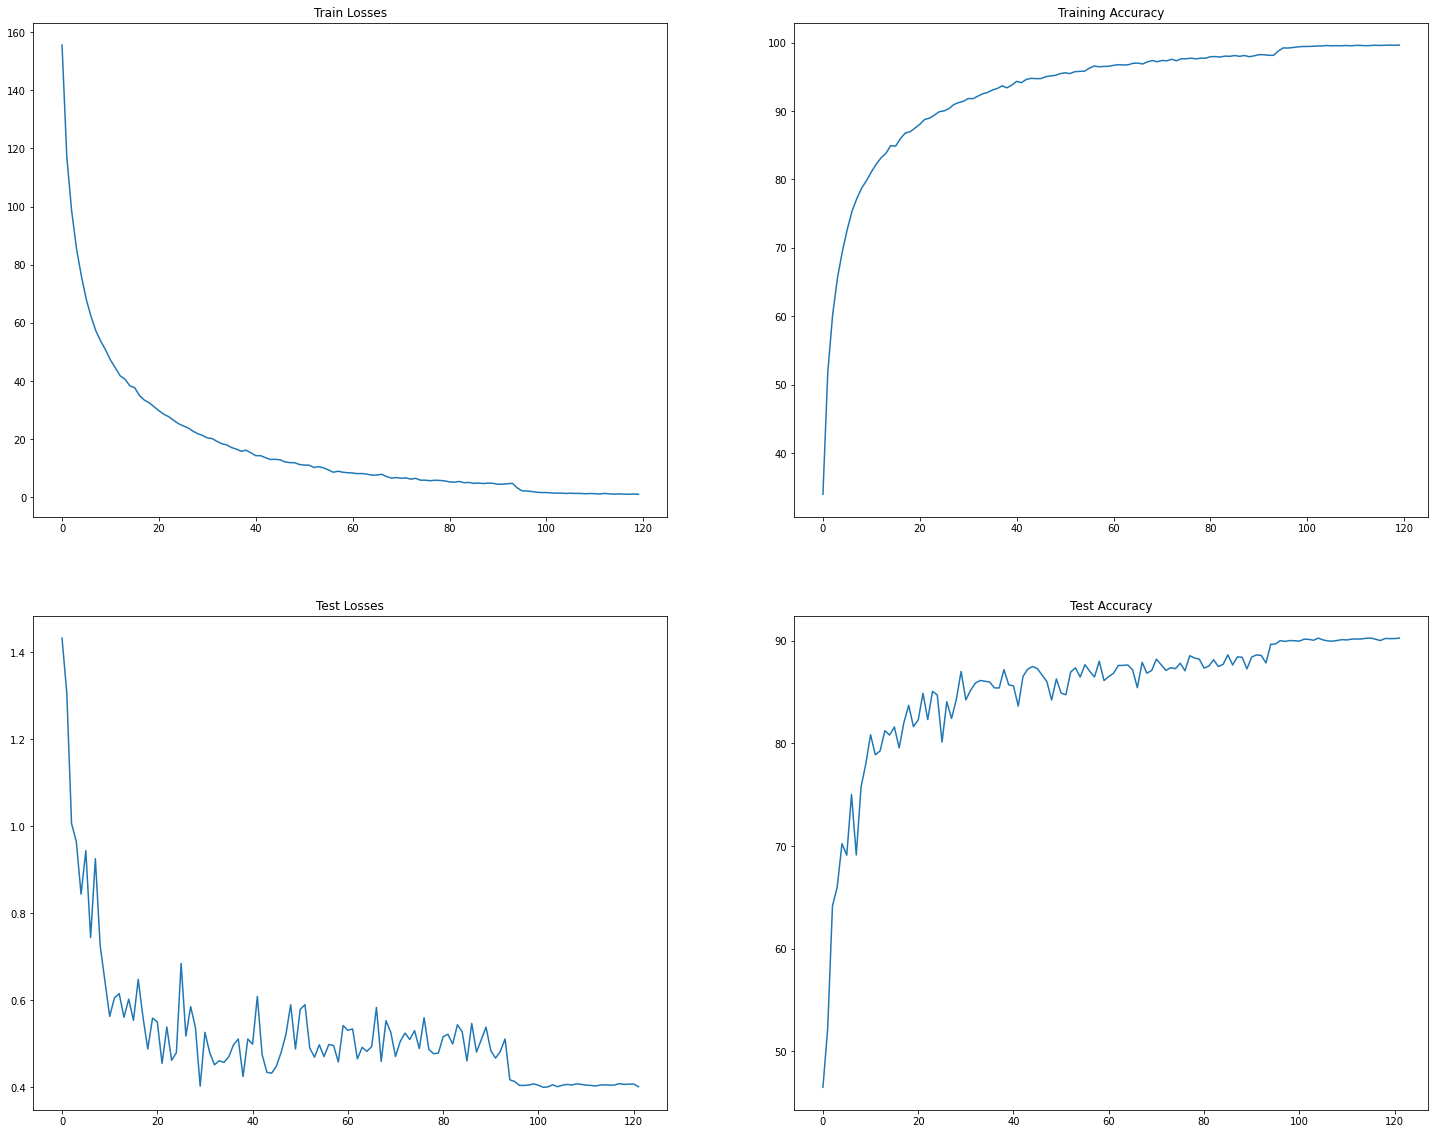

In [18]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)